In [1]:
import math
import random
from sympy import *
import numpy as np
from IPython.display import display, Markdown
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import cm
import tracemalloc
from time import time

In [2]:
x1 = Symbol('x1')
x2 = Symbol('x2')
# f = simplify(x1 ** 2 + x2 ** 2 + 6 * x1 - 10*x2)


# f1 = simplify(x1**2 + x2**2 + 6 * x1 - 10 * x2 + x1**4)
f1 = simplify(100 * (x2 - x1)**2 + (1 - x1)**2)
f2 = simplify(100 * (x2 - x1 ** 2) ** 2 + (1 - x1) ** 2)
f3 = -simplify(2 * exp(-(x1 - 1) ** 2 / 4 - (x2 - 1) ** 2 / 1) + 3 * exp(-(x1 - 2) ** 2 / 9 - (x2 - 3) ** 2 / 4))
f4 = simplify(2 * (x2 - x1)**2 + (1 - x1)**2)
freeSyms = [x1, x2]


funcs = [f1, f2, f3, f4]

class Statistic:
    def __init__(self):
        self.__start_time = None
        self.elapsed_time = 0.0
        self.memory = 0
        self.optimizer_calls = 0
        self.function_calls = 0
        self.gradient_calls = 0
        self.hessian_calls = 0

    def start_clock(self):
        self.__start_time = time()

    def stop_clock(self):
        self.elapsed_time += time() - self.__start_time
        self.__start_time = None

    def start_trace(self):
        tracemalloc.start()

    def stop_trace(self):
        res = tracemalloc.take_snapshot()
        stats = res.statistics(cumulative=True, key_type='filename')
        for stat in stats:
            self.memory += stat.size
        tracemalloc.stop()

    def start(self):
        self.start_clock()
        self.start_trace()

    def stop(self):
        self.stop_clock()
        self.stop_trace()

def print_stat(stat: Statistic):
    print('time:           ', stat.elapsed_time)
    print('memory:         ', stat.memory)
    print('optimizer_calls:', stat.optimizer_calls)
    print('function_calls: ', stat.function_calls)
    print('gradient_calls: ', stat.gradient_calls)
    print('hessian_calls:  ', stat.hessian_calls)

class FunctionWrapper:
    def __init__(self, name, f, a, b, e, der, stat: Statistic):
        self.stat = stat
        self.f = f # function
        self.der = der # deriative
        self.a = a # bounds
        self.b = b #
        self.e = e # accuracy
        self.name = name
    def __str__(self):
        return self.name + " on " + "[" + str(self.a) + ", " + str(self.b) + "]"


class OptimizeResult:
    def __init__(self, method_name, f: FunctionWrapper, iterations, calls, result, data, stat: Statistic):
        self.stat = stat
        self.iterations  = iterations
        self.method_name = method_name
        self.f           = f
        self.calls       = calls
        self.result      = result
        self.data        = data

    def __str__(self):
        return "Result of " + self.method_name + " for {" + str(self.f) + "} is " + str(self.result)

# Часть 1: методы одномерного поиска

## Метод дихотомии

In [3]:
def dichotomy(w: FunctionWrapper) -> OptimizeResult:
    result = OptimizeResult("dichotomy", w, 0, 0, 0, [], None)
    w.stat.optimizer_calls += 1

    d = random.uniform(0.2, 1.0) * (w.e / 2)

    a = w.a
    b = w.b
    while (b - a > w.e):
        result.data.append((a, b))
        x1 = (a + b) / 2 - d
        x2 = (a + b) / 2 + d
        y1 = w.f(x1)
        w.stat.function_calls += 1
        y2 = w.f(x2)
        w.stat.function_calls += 1


        if (y1 < y2):
            b = x2
        elif (y2 < y1):
            a = x1
        else:
            a = x1
            b = x2

        result.iterations += 1
        result.calls += 2

    result.result = (a + b) / 2
    return result

## Метод золотого сечения

In [4]:
def golden_ratio(w: FunctionWrapper) -> OptimizeResult:
    result = OptimizeResult("golden ratio", w, 0, 0, 0, [], None)
    w.stat.optimizer_calls += 1

    a = w.a
    b = w.b
    if (b - a < w.e):
        result.result = (a + b) / 2
        return result

    gr = (math.sqrt(5) + 1) / 2

    x1 = b - (b - a) / gr
    x2 = a + (b - a) / gr

    y1 = w.f(x1)
    w.stat.function_calls += 1
    y2 = w.f(x2)
    w.stat.function_calls += 1

    result.calls += 2

    while (b - a > w.e):
        result.data.append((a, b))
        if (y1 < y2):
            b = x2
            (x2, y2) = (x1, y1)
            x1 = b - (b - a) / gr
            y1 = w.f(x1)
            w.stat.function_calls += 1
        else:
            a = x1
            (x1, y1) = (x2, y2)
            x2 = a + (b - a) / gr
            y2 = w.f(x2)
            w.stat.function_calls += 1

        result.iterations += 1
        result.calls += 1

    result.result = (a + b) / 2
    return result

## Метод Фибоначчи

In [5]:
def fibonacci(w: FunctionWrapper) -> OptimizeResult:
    def fib(i):
        (a, b) = (0, 1)
        for j in range(0, i):
            temp = b
            b += a
            a = temp
        return a
    def fib_greater(t):
        (a, b) = (0, 1)
        j = 0
        while True:
            if a > t:
                return j - 2
            temp = b
            b += a
            a = temp
            j += 1
    w.stat.optimizer_calls += 1
    calls = fib_greater((w.b - w.a) / w.e)
    result = OptimizeResult("fibonacci", w, 0, calls, 0, [], None)

    n = calls
    x1 = w.a + (w.b - w.a) * (fib(n - 2) / fib(n))
    x2 = w.a + (w.b - w.a) * (fib(n - 1) / fib(n))
    y1 = w.f(x1)
    w.stat.function_calls += 1
    y2 = w.f(x2)
    w.stat.function_calls += 1
    a = w.a
    b = w.b

    while (n > 1):
        result.data.append((a, b))
        result.iterations += 1
        n -= 1
        if (y1 > y2):
            a = x1
            (x1, y1) = (x2, y2)
            x2 = a + b - x1
            y2 = w.f(x2)
            w.stat.function_calls += 1
        else:
            b = x2
            (x2, y2) = (x1, y1)
            x1 = a + b - x2
            y1 = w.f(x1)
            w.stat.function_calls += 1

    result.result = (x1 + x2) / 2
    # display('optresult ' +  str(w.f(result.result)))
    return result


In [6]:
def hessian(func):
    fs = freeSyms
    return Matrix(derive_by_array(derive_by_array(func, fs), fs))

def gradient(func):
    return Matrix(derive_by_array(func, freeSyms))

def evalf(f, x):
    return f.evalf(subs=dict(zip(freeSyms, x)))

def substitute(u, x):
    return Matrix(u.applyfunc(lambda k: k.evalf(subs=dict(zip(freeSyms, x)))))

def positive_definitive(m):
    eigenvalues = np.linalg.eigvals(m)
    if all(eigenvalues > 0):
        return m
    else:
        min_eig = min(eigenvalues)
        add = 2 * (-min_eig) * np.eye(m.shape[0])
        return m + add

In [7]:
def better_trajectory(plot_name, func, x1, y1, x2, y2, grad_data):
    npts = 100
    RGB = 25
    fig = plt.figure(figsize=(12,12))
    x, y = np.mgrid[x1:y1:100j,
                x2:y2:100j]
    z = func(x, y)
    fig.suptitle(plot_name, fontsize=26)
    # contour
    ax = fig.add_subplot(111)
    # display(z)
    plt.xlim(x1, y1)
    plt.ylim(x2, y2)
    plt.contourf(x, y, z, levels=10)
    plt.colorbar()
    plt.title('contour')

    #
    ax.plot([x[0] for x in grad_data], [x[1] for x in grad_data], color='r')
    #
    plt.show()

# Арифметические операции

In [8]:
class OptimizationParameters:
    def __init__(self, function, optimizer_name, start_x, eps):
        self.start_x = start_x
        self.optimizer_name = optimizer_name
        self.eps = eps
        self.function = function

def optimizer(optimizer_name):
    if optimizer_name == "fibo":
        return fibonacci
    elif optimizer_name == "dicho":
        return dichotomy
    elif optimizer_name == "golden":
        return golden_ratio

In [9]:
def makeShiftWrapper(f, x, p, eps, stat):
    return FunctionWrapper("", lambda shift: evalf(f, x + p * shift),
                              0, 1000.01, eps, None, stat)

def newton(opt_params: OptimizationParameters) -> OptimizeResult:

    result = OptimizeResult("newton", 0, 0, 0, 0, [], Statistic())
    result.stat.start()
    h = hessian(opt_params.function)
    grad = gradient(opt_params.function)
    prevX = Matrix([float('inf')] * opt_params.start_x.shape[0])
    curX = opt_params.start_x

    result.data.append(curX)
    while result.iterations < 50 and (curX - prevX).dot(curX - prevX) > opt_params.eps:
        prevX = curX
        curHes = substitute(h, curX)
        result.stat.hessian_calls += 1
        fixedCurHes = Matrix(positive_definitive(np.array(curHes, dtype=float)))
        direction = fixedCurHes.inv() * substitute(grad, curX)
        result.stat.gradient_calls += 1
        opt = makeShiftWrapper(opt_params.function, curX, -direction, opt_params.eps, result.stat)

        curX = curX - direction * optimizer(opt_params.optimizer_name)(opt).result
        result.iterations += 1
        result.data.append(curX)
    result.stat.stop()
    result.result = curX
    return result



In [10]:
def conjugate_gradients(opt_params: OptimizationParameters) -> OptimizeResult:
    def nextAlpha(f, curX, p, stat):
        opt = makeShiftWrapper(f, curX, p, opt_params.eps, stat)
        return optimizer(opt_params.optimizer_name)(opt).result

    def nextX(curX, alpha, p):
        # display('delta ' +  str(alpha * p))
        return curX + alpha * p
    result = OptimizeResult("gradients", 0, 0, 0, 0, [], Statistic())
    result.stat.start()

    grad = gradient(opt_params.function)

    prevX = Matrix([float('inf')] * opt_params.start_x.shape[0])
    curX = opt_params.start_x  #x_0

    p = -substitute(grad, curX) #p_1
    gradOnX = substitute(grad, curX)
    result.stat.gradient_calls += 1
    result.data.append(curX)
    while result.iterations < 50 and (curX - prevX).dot(curX - prevX) > opt_params.eps :
        alpha = nextAlpha(opt_params.function, curX, p, result.stat) #alpha_k
        prevX = curX                  #x_k-1
        gradOnPrevX = gradOnX
        curX = nextX(curX, alpha, p)  #x_k

        gradOnX = substitute(grad, curX)
        result.stat.gradient_calls += 1

        if result.iterations % curX.shape[0] == 0:
            beta = 0.0 #beta_k
        else:
            beta = -gradOnX.dot(gradOnX) / gradOnPrevX.dot(gradOnPrevX)
        p = -gradOnX + beta * p #p_k+1
        result.data.append(curX)
        result.iterations = result.iterations + 1
    result.stat.stop()
    result.result = curX
    return result

In [11]:

def gradient_descent(opt_params: OptimizationParameters) -> OptimizeResult:
    f = opt_params.function
    result = OptimizeResult("grad descent", f, 0, 0, 0, [], Statistic())
    result.stat.start()
    grad = gradient(f)

    prevX = Matrix([float('inf')] * opt_params.start_x.shape[0])
    curX = opt_params.start_x
    while result.iterations < 50 and (curX - prevX).dot(curX - prevX) > opt_params.eps:
        prevX = curX                  #x_k-1
        result.iterations += 1
        result.data.append(curX)
        gradOnX = -substitute(grad, curX)
        result.stat.gradient_calls += 1
        opt = makeShiftWrapper(f, curX, gradOnX, opt_params.eps, result.stat)
        alpha = optimizer(opt_params.optimizer_name)(opt).result
        curX = curX + gradOnX * alpha
    result.result = curX
    result.stat.stop()
    return result

# Отчет


## Сравнение

In [12]:
start_points = [Matrix([-5, 5]), Matrix([2, 5]), Matrix([-5, -5]), Matrix([0, 5])]
optimizer_name = "fibo"
eps = 1e-5
methods = [(conjugate_gradients, 'conjugate gradients'), (newton, 'newton'), (gradient_descent, 'gradient descent')]
functions_to_compare_on = funcs

for func in functions_to_compare_on:
    for start_point in start_points:

        print(func)
        print('Start point', str(start_point))
        print()
        for method in methods:
            print(method[1])
            result = method[0](OptimizationParameters(func, optimizer_name, start_point, eps))
            print_stat(result.stat)
            print('x =', result.result)
            print('y =', evalf(func, result.result))
            print()
        print('–'*80)



(x1 - 1)**2 + 100*(x1 - x2)**2
Start point Matrix([[-5], [5]])

conjugate gradients
time:            2.787393093109131
memory:          2578142
optimizer_calls: 21
function_calls:  819
gradient_calls:  22
hessian_calls:   0
x = Matrix([[0.190751085796754], [0.186564195980597]])
y = 0.656636809772397

newton
time:            0.3161799907684326
memory:          405199
optimizer_calls: 2
function_calls:  78
gradient_calls:  2
hessian_calls:   2
x = Matrix([[0.999999999732779], [1.00000000017815]])
y = 1.99067288702500e-17

gradient descent
time:            6.188714027404785
memory:          2194060
optimizer_calls: 50
function_calls:  1950
gradient_calls:  50
hessian_calls:   0
x = Matrix([[0.679508981990884], [0.671378253118046]])
y = 0.109325367824880

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
(x1 - 1)**2 + 100*(x1 - x2)**2
Start point Matrix([[2], [5]])

conjugate gradients
time:            1.56899094581604
memory:          2066511
optimizer_calls

## Графики

(x1 - 1)**2 + 100*(x1 - x2)**2

'Start point'

Matrix([
[-5],
[ 5]])

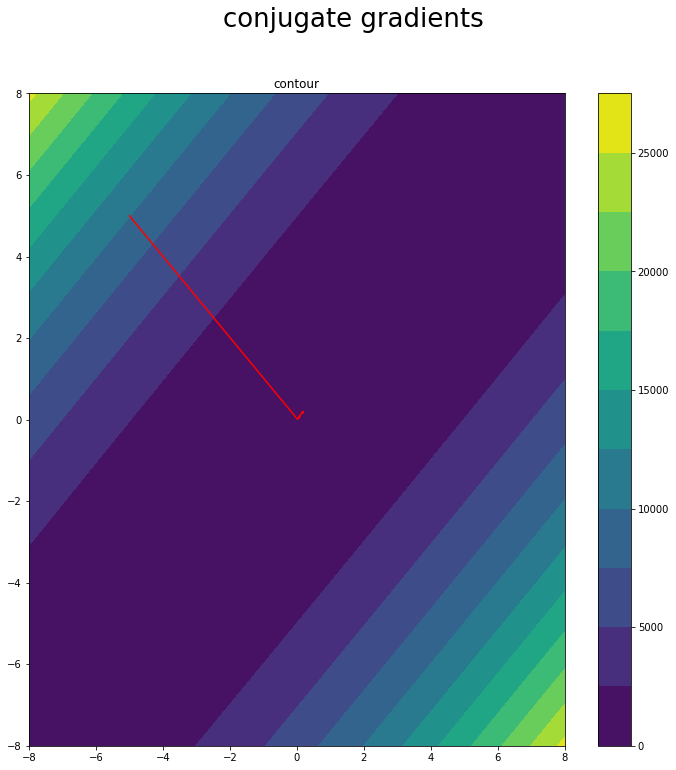

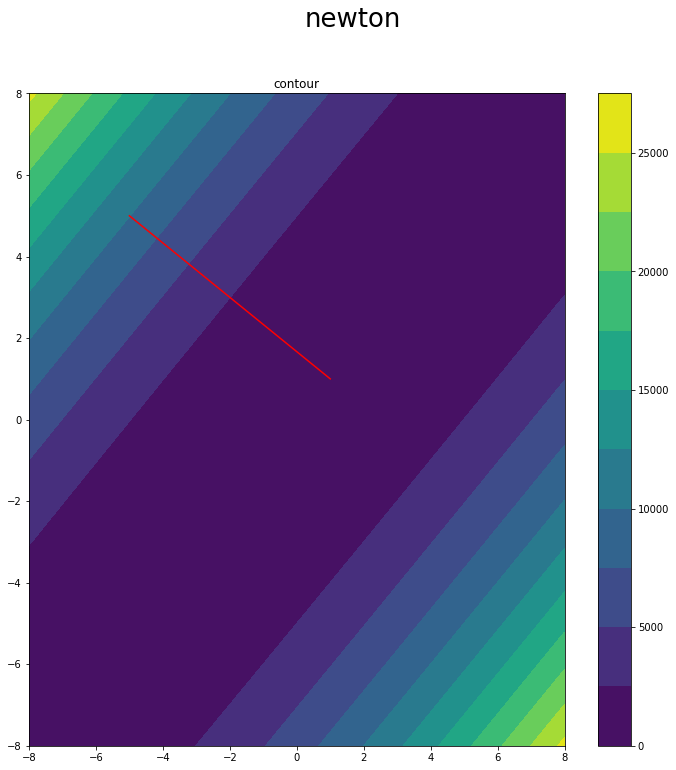

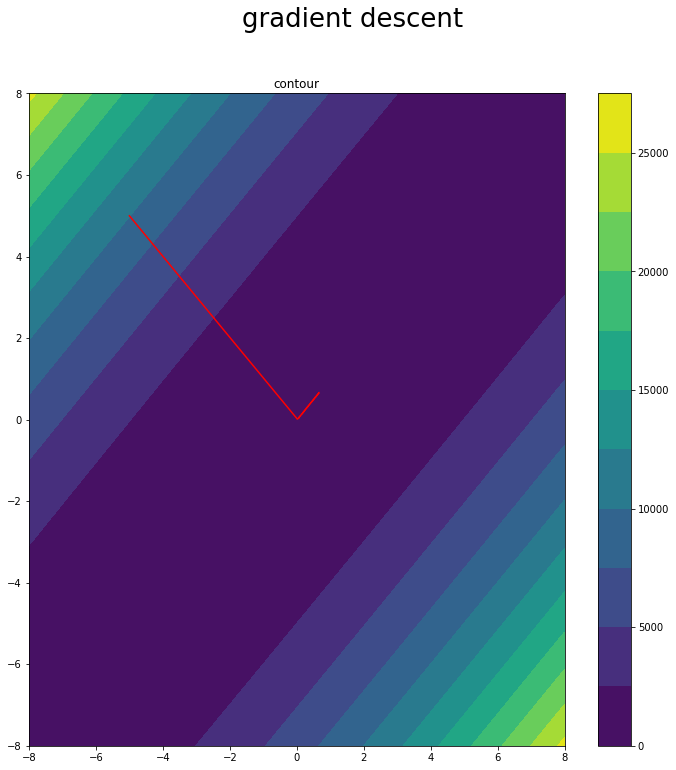

'Start point'

Matrix([
[2],
[5]])

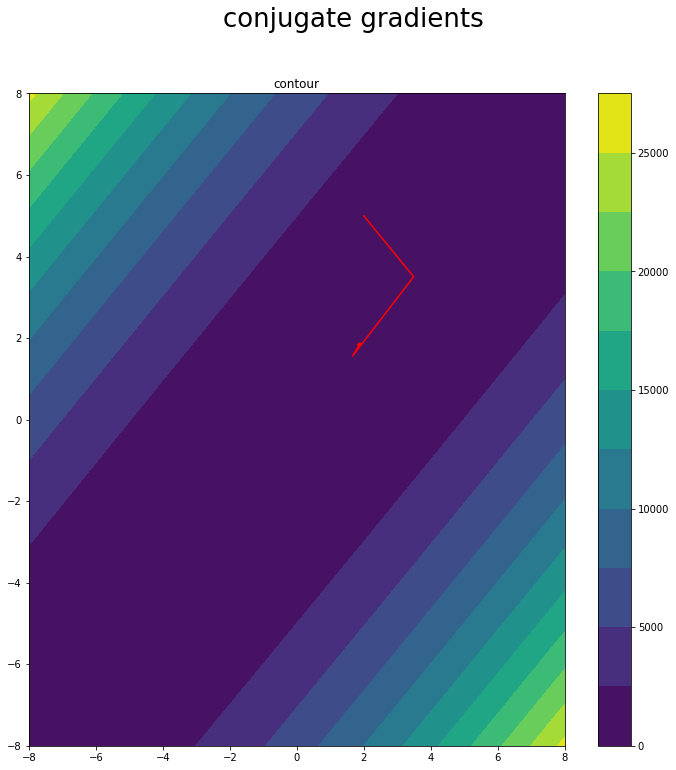

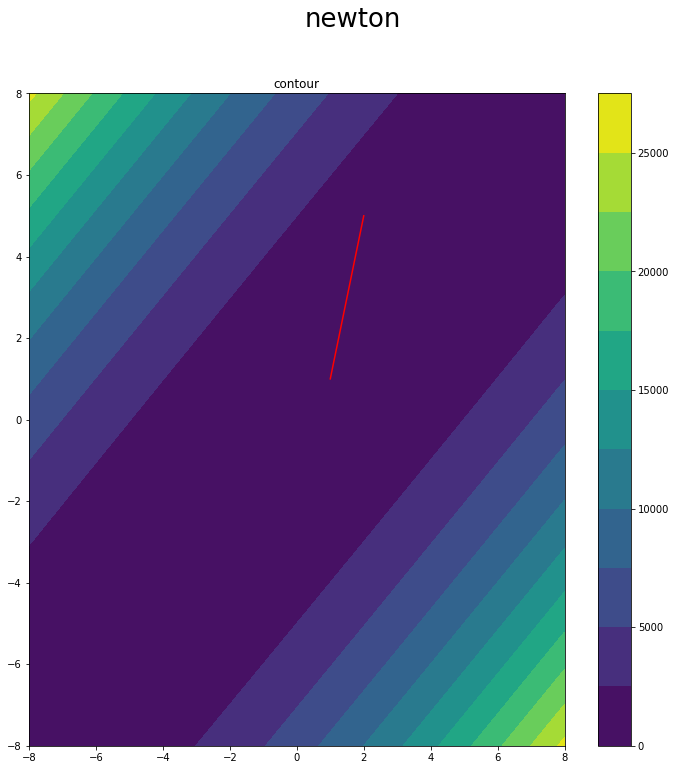

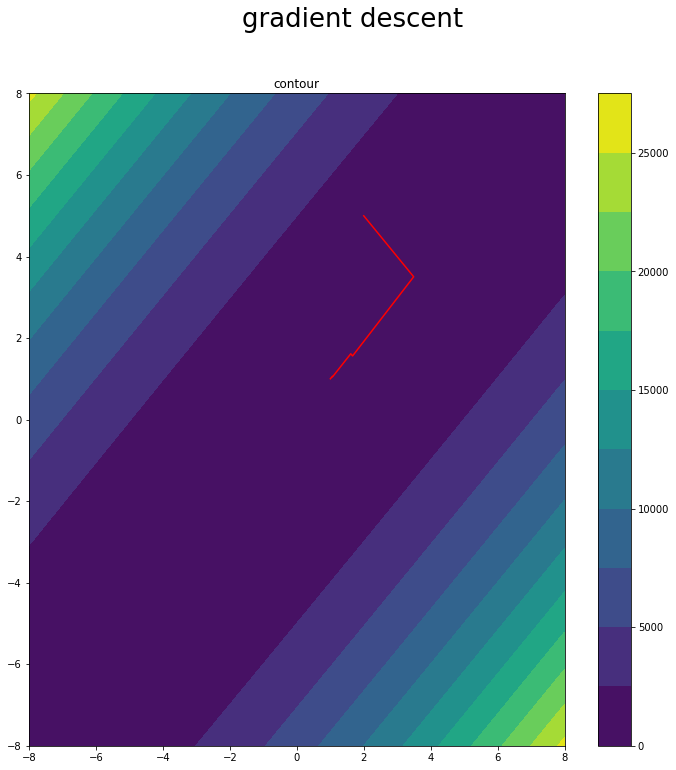

'Start point'

Matrix([
[-5],
[-5]])

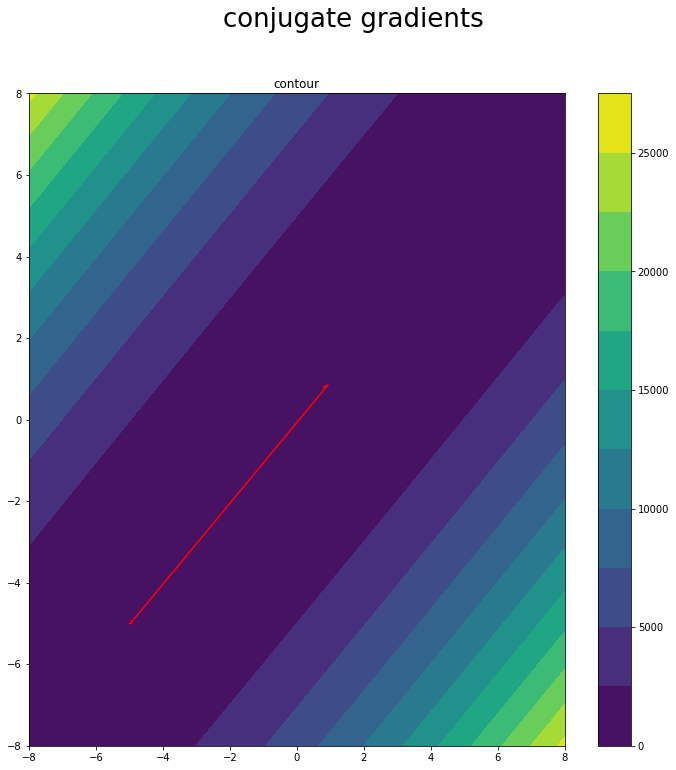

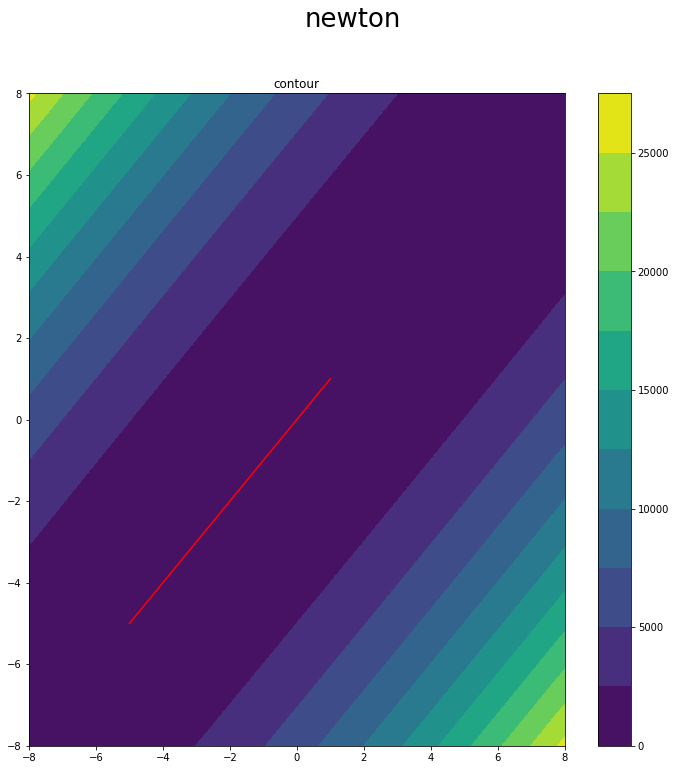

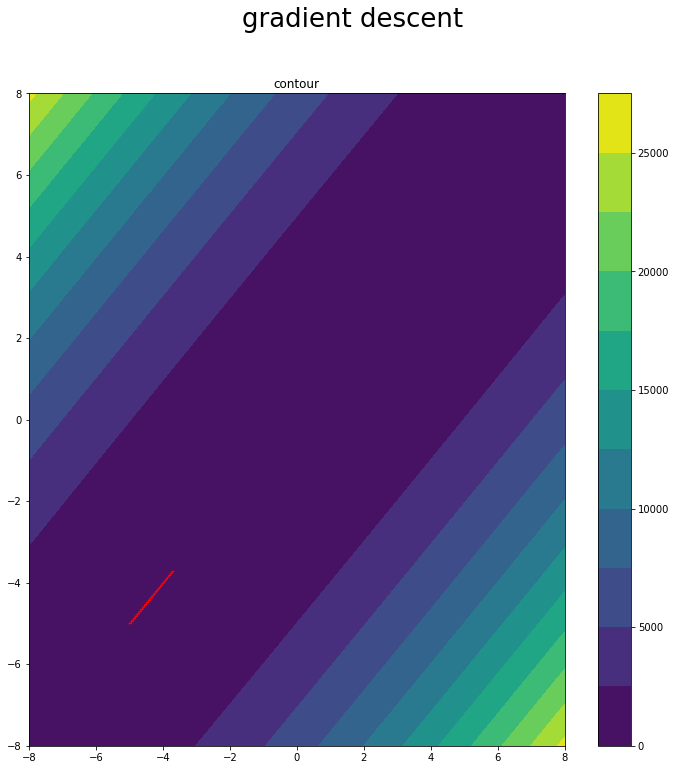

'Start point'

Matrix([
[0],
[5]])

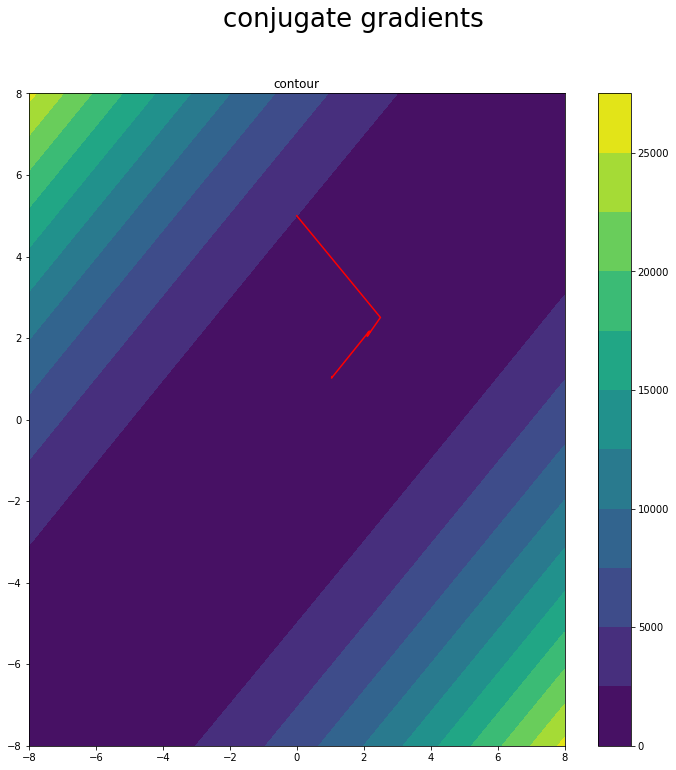

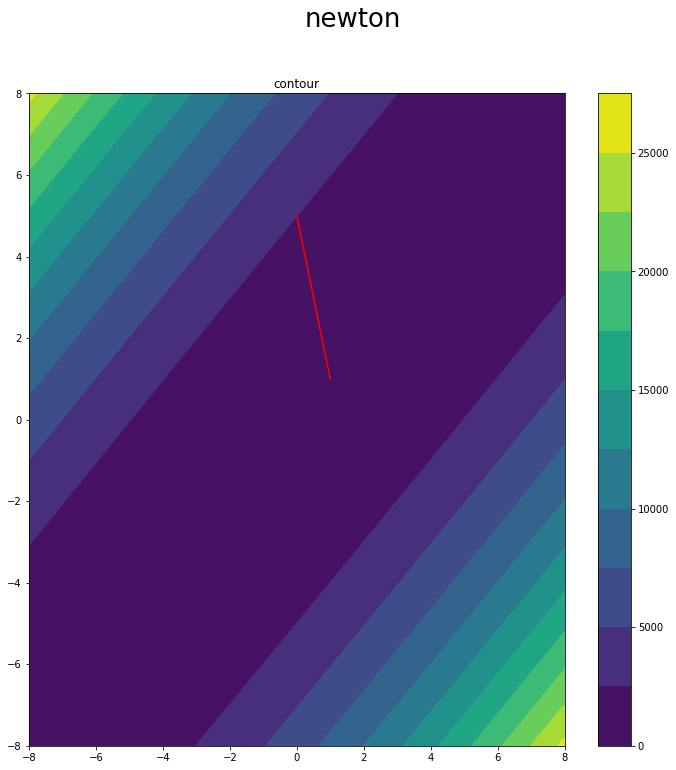

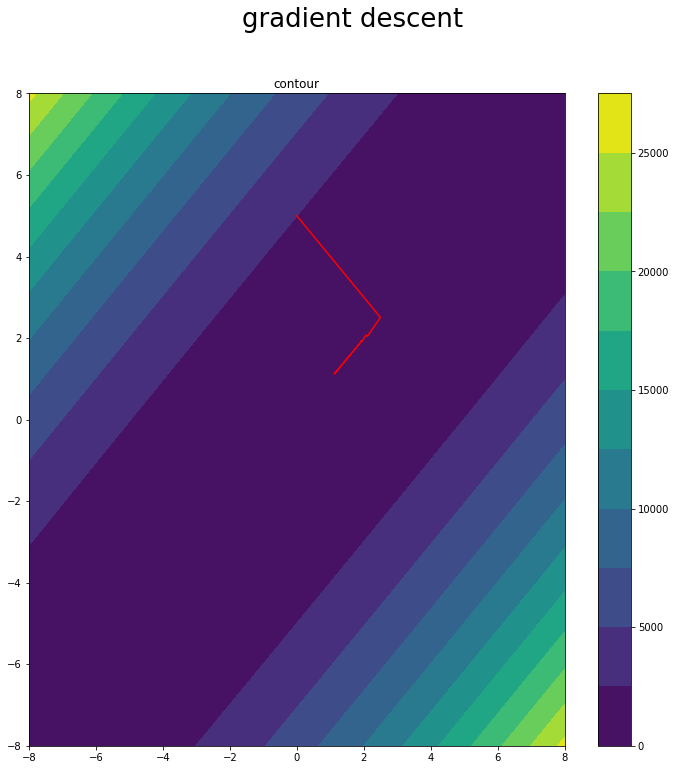

(x1 - 1)**2 + 100*(x1**2 - x2)**2

'Start point'

Matrix([
[-5],
[ 5]])

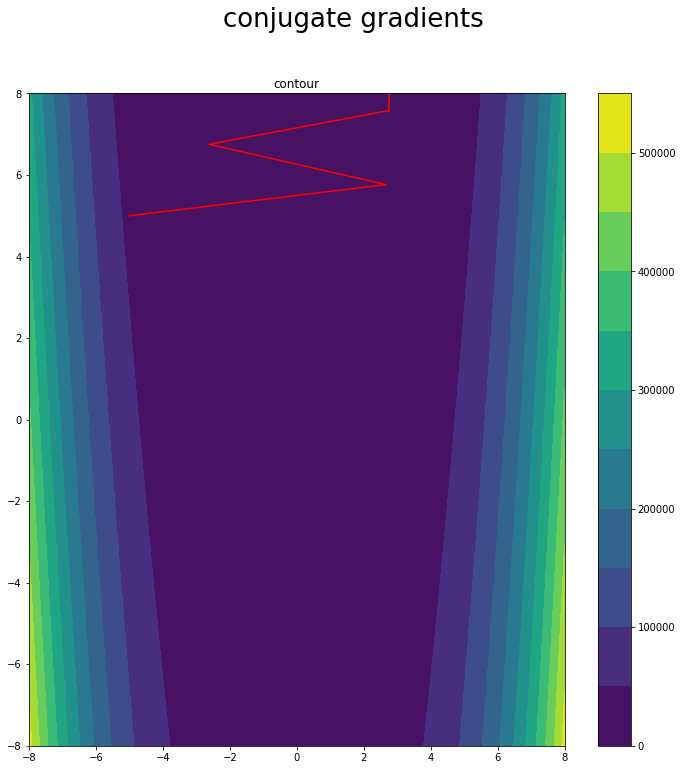

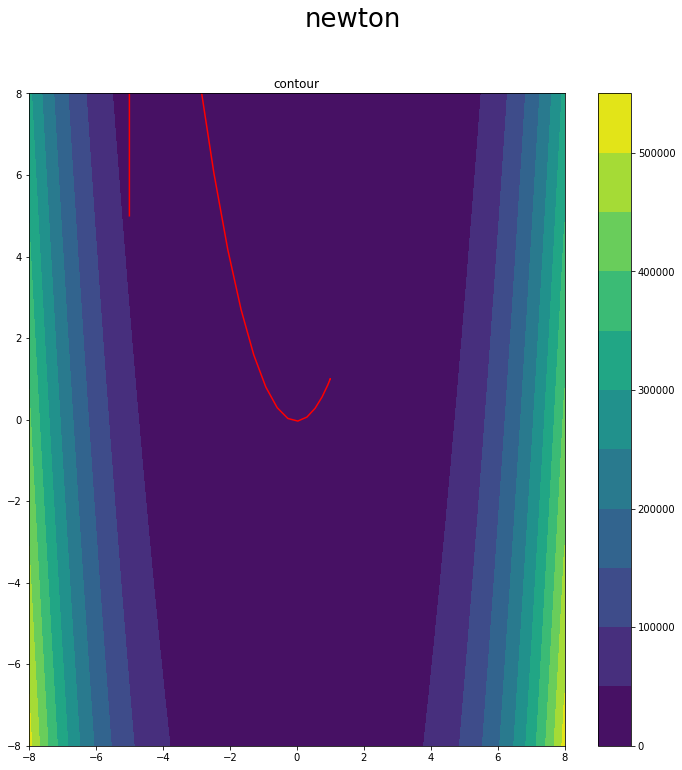

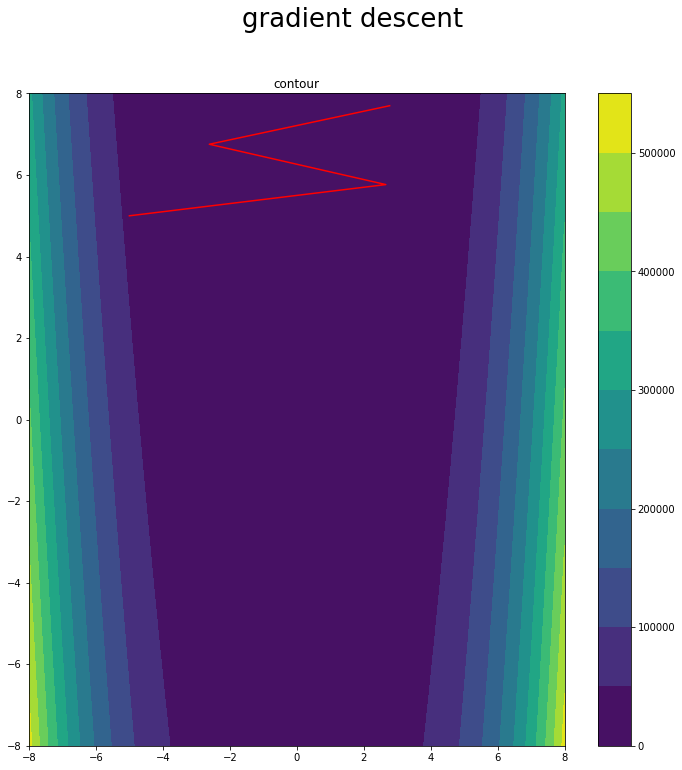

'Start point'

Matrix([
[2],
[5]])

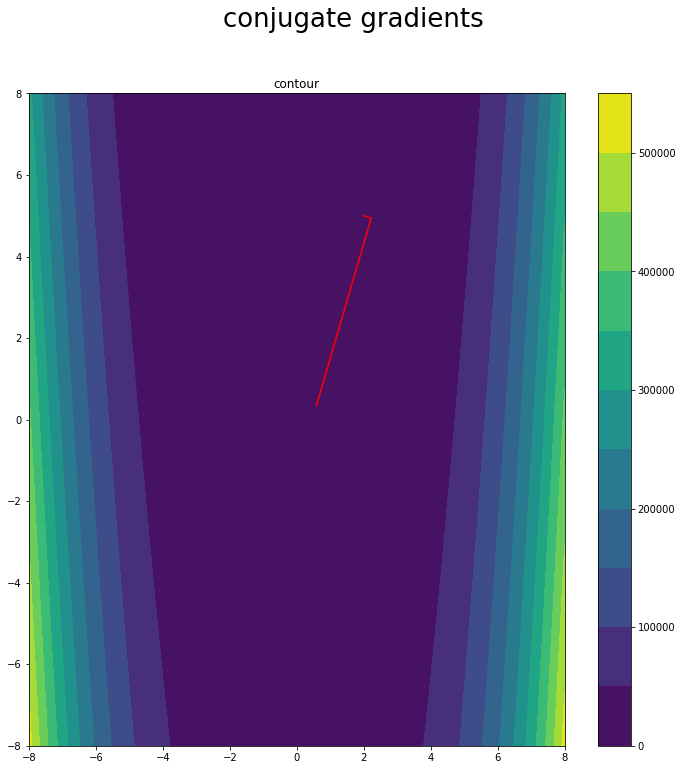

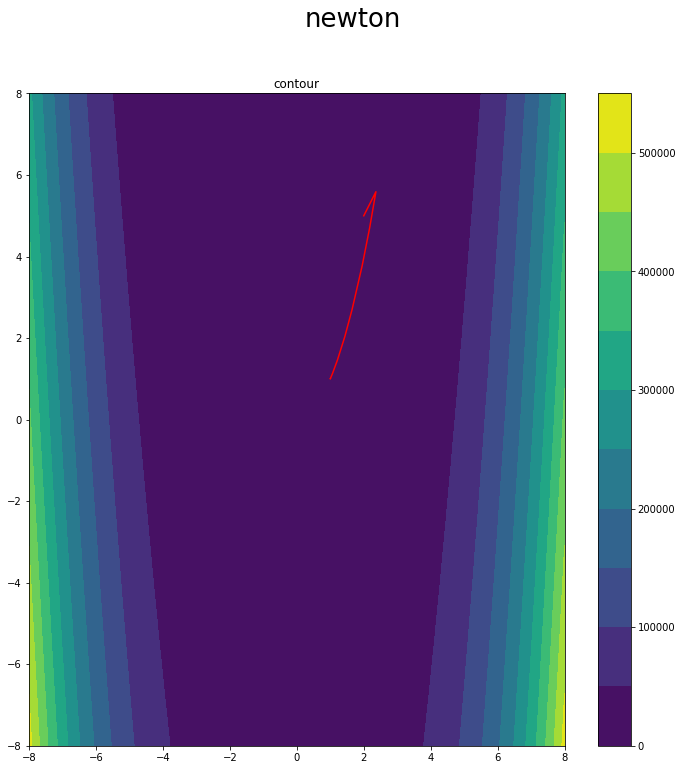

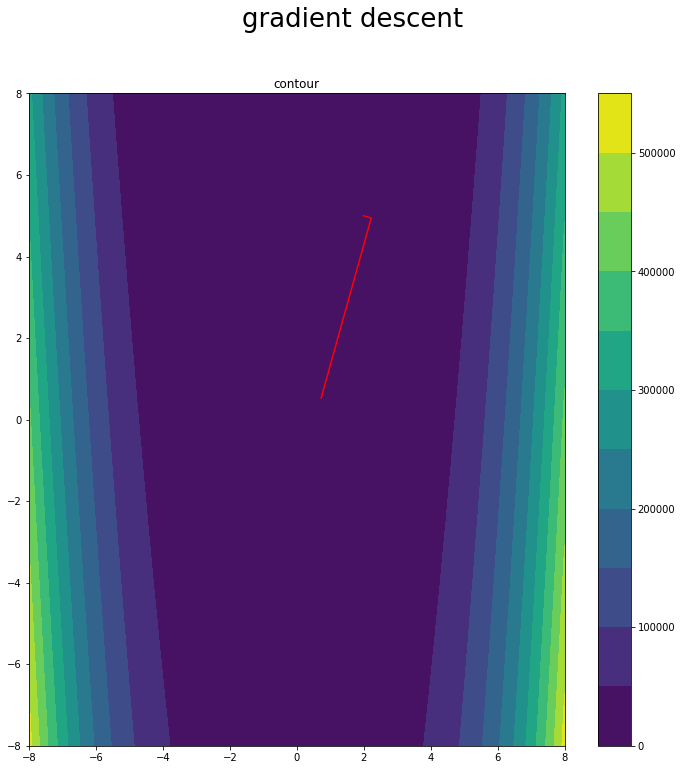

'Start point'

Matrix([
[-5],
[-5]])

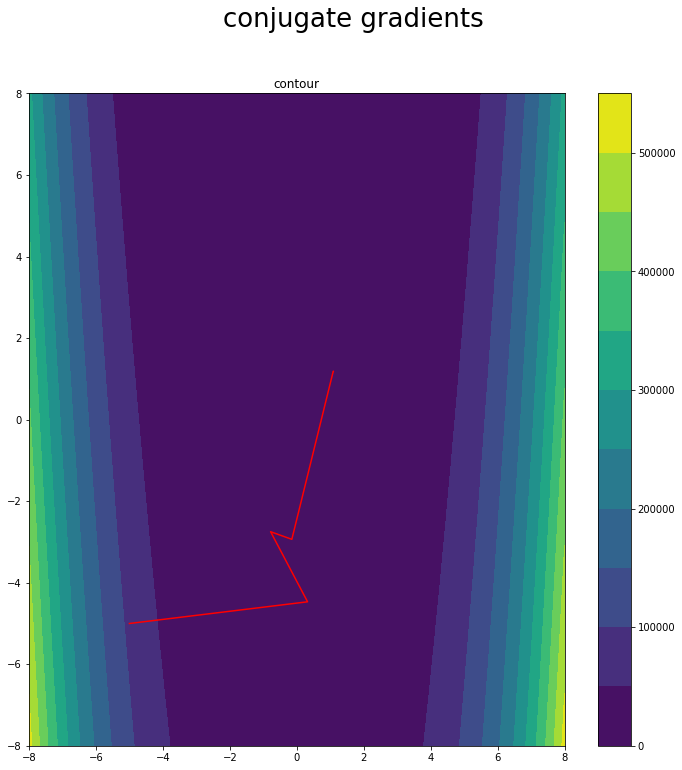

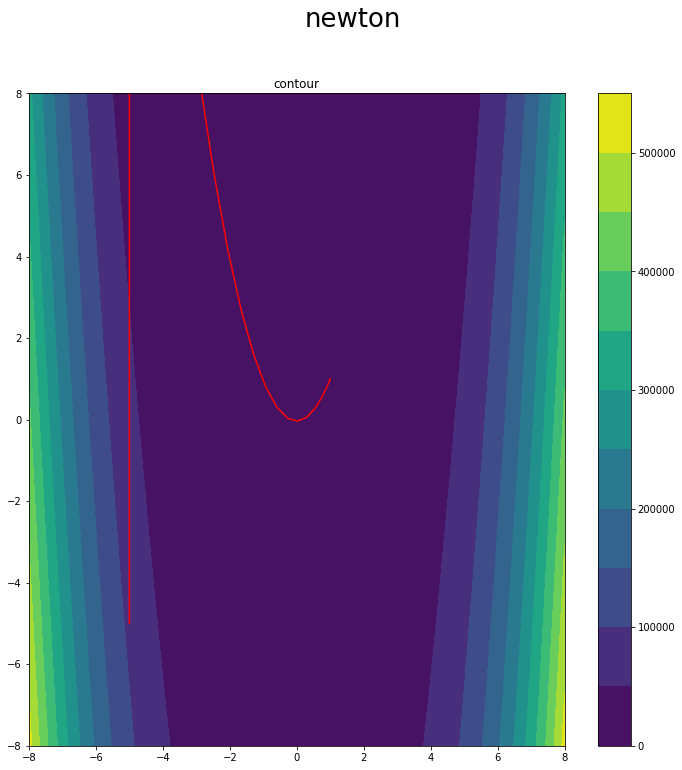

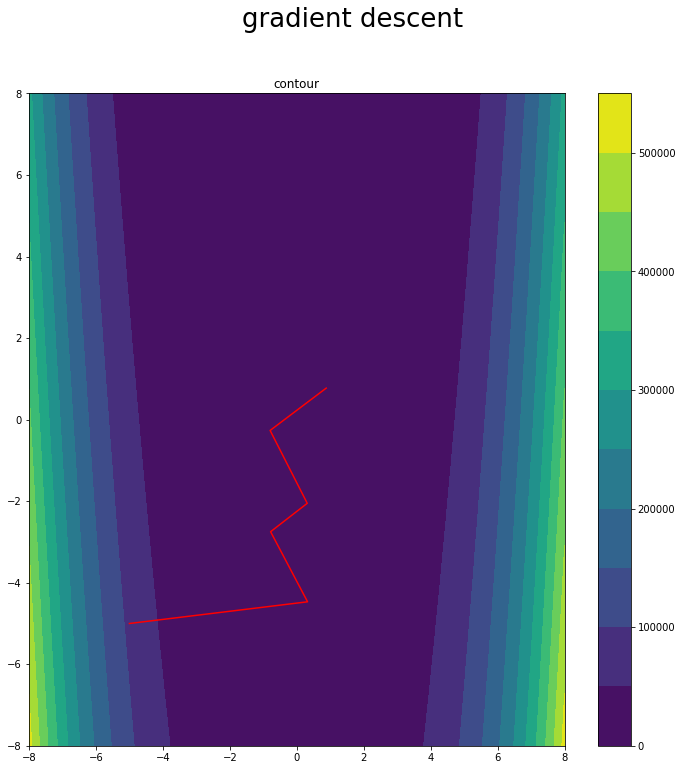

'Start point'

Matrix([
[0],
[5]])

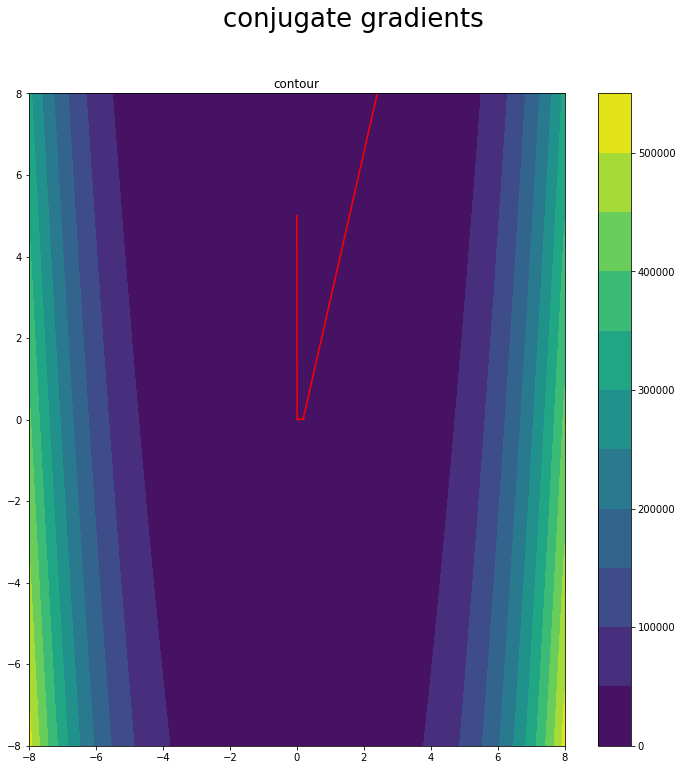

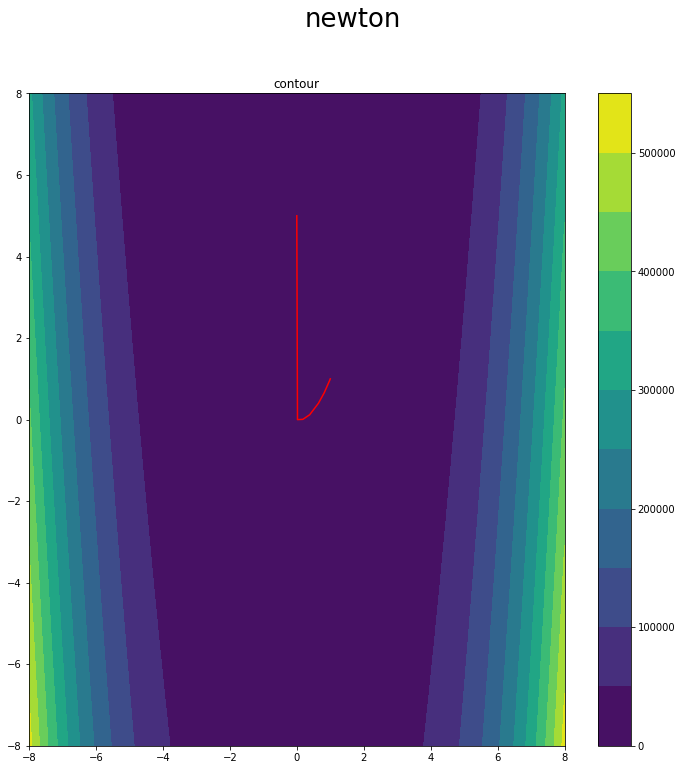

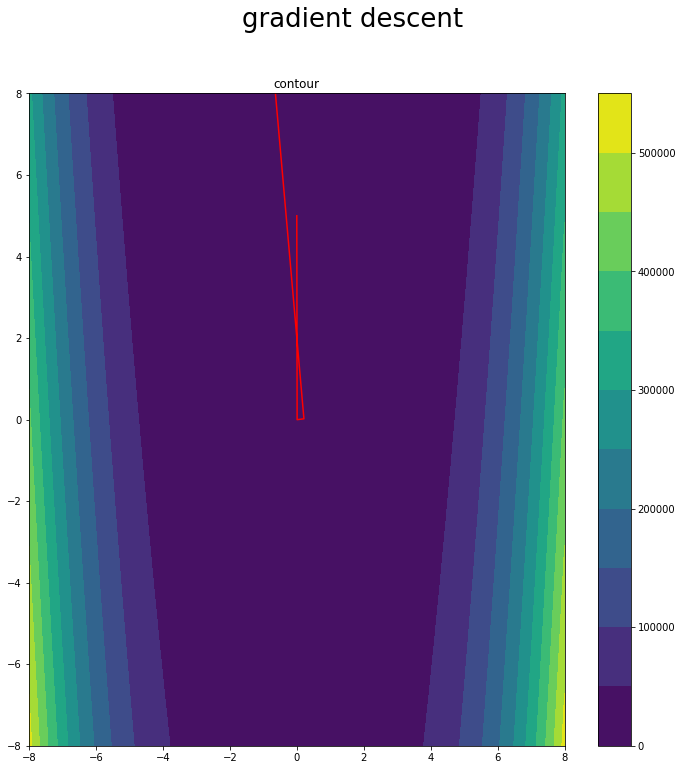

-3*exp(-(x1 - 2)**2/9 - (x2 - 3)**2/4) - 2*exp(-(x1 - 1)**2/4 - (x2 - 1)**2)

'Start point'

Matrix([
[-5],
[ 5]])

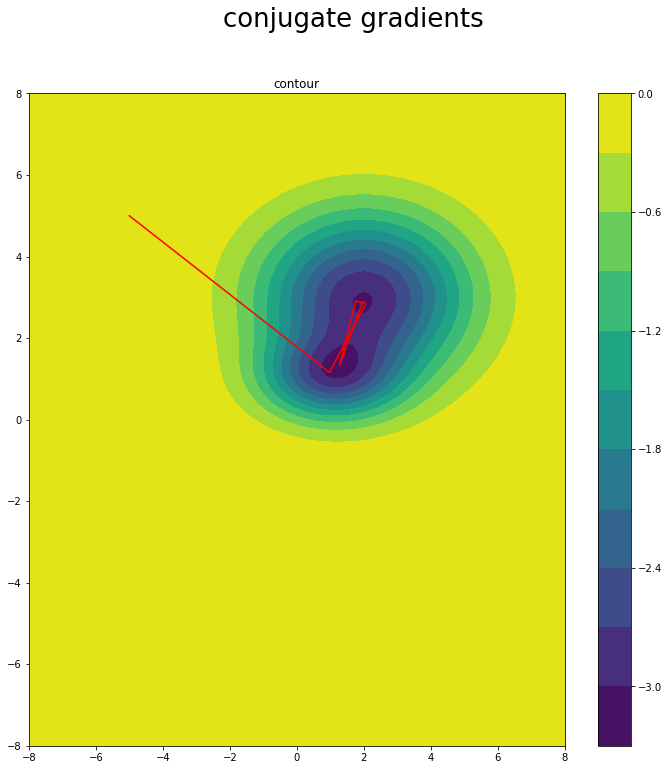

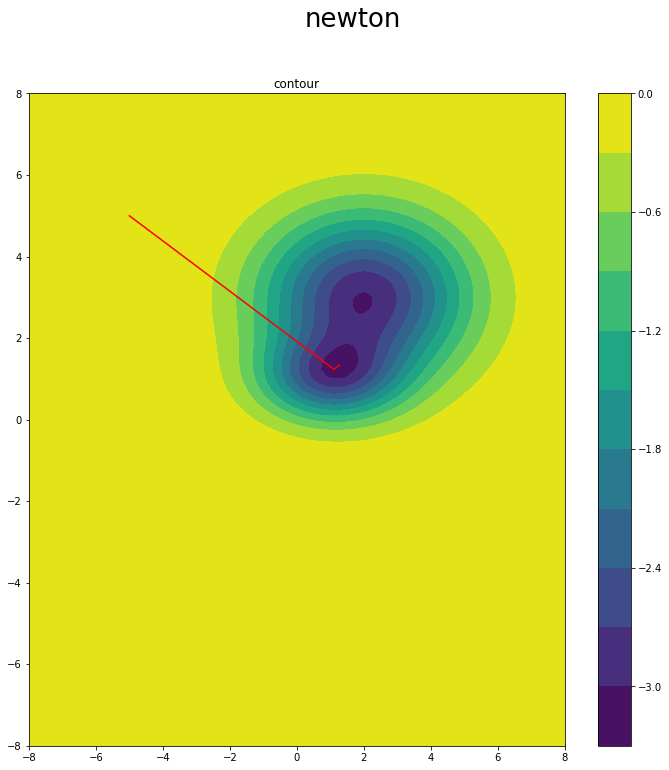

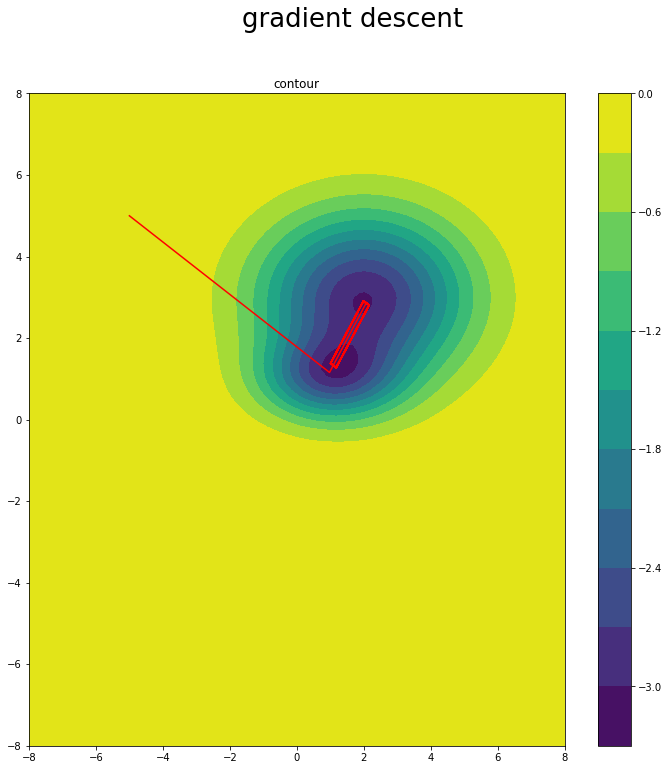

'Start point'

Matrix([
[2],
[5]])

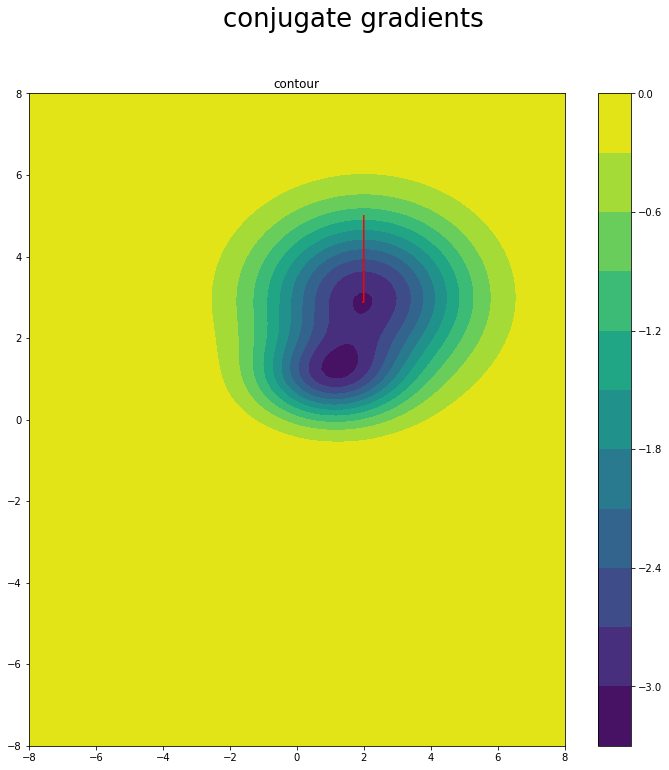

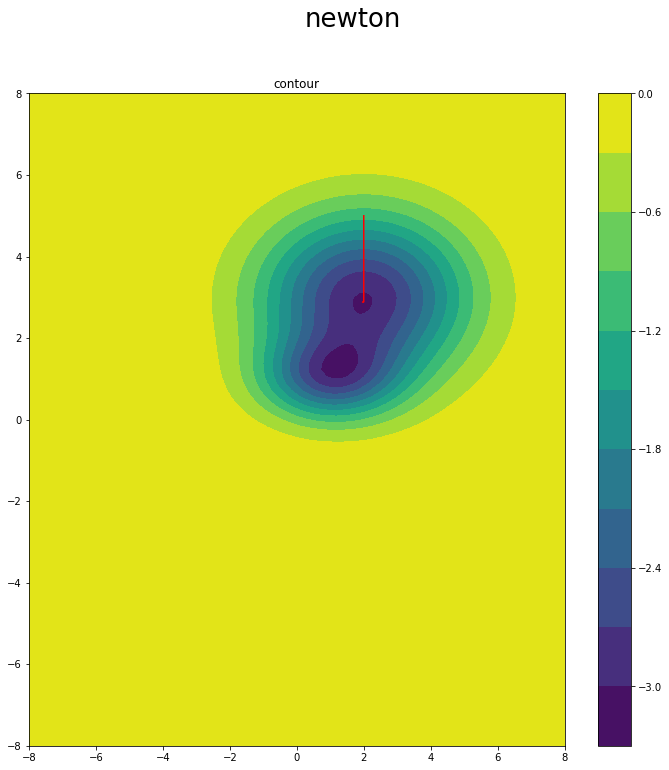

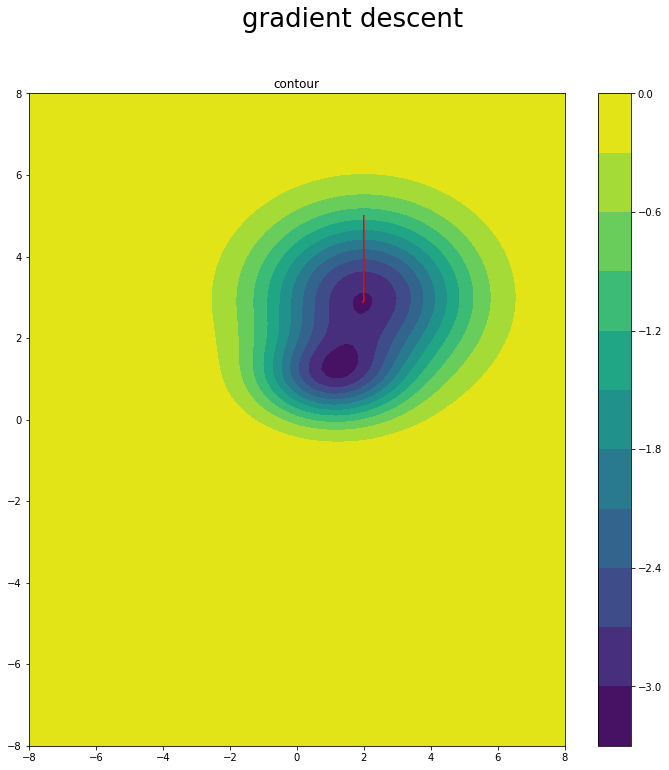

'Start point'

Matrix([
[-5],
[-5]])

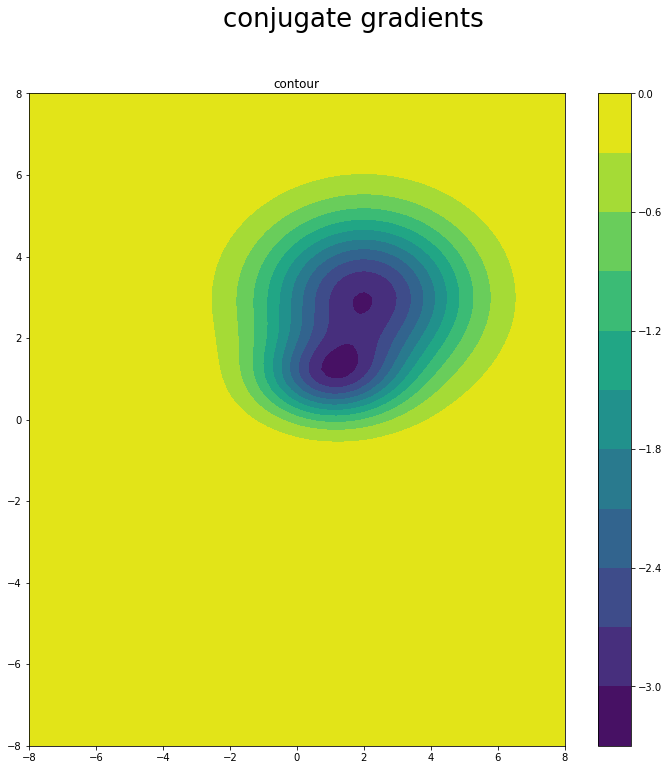

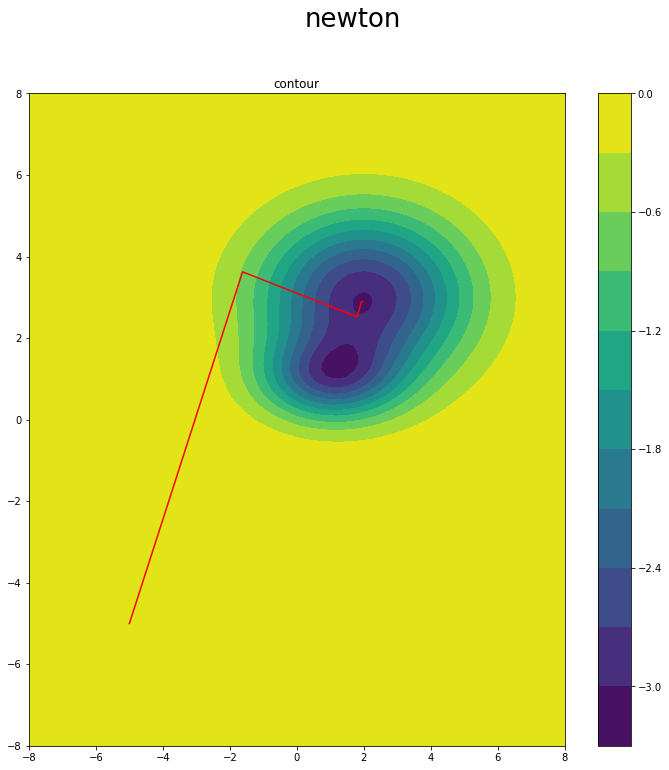

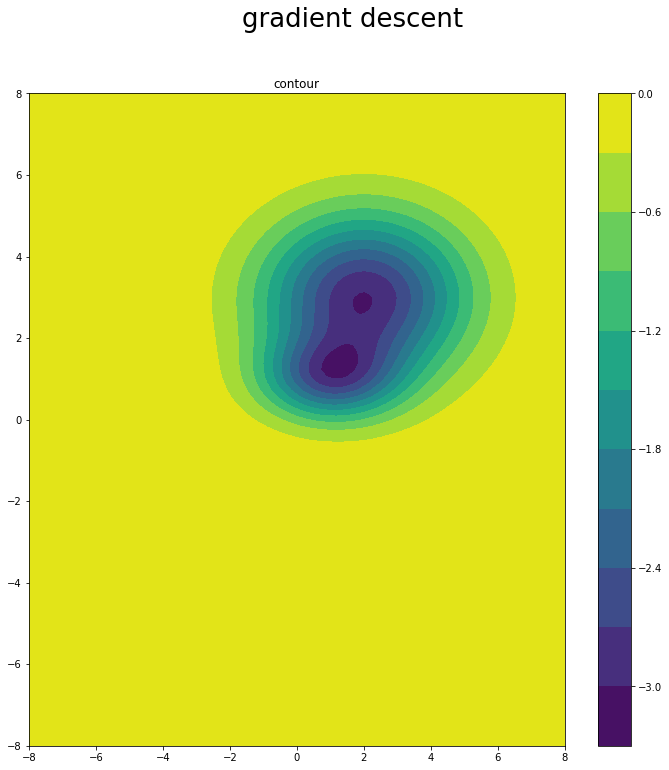

'Start point'

Matrix([
[0],
[5]])

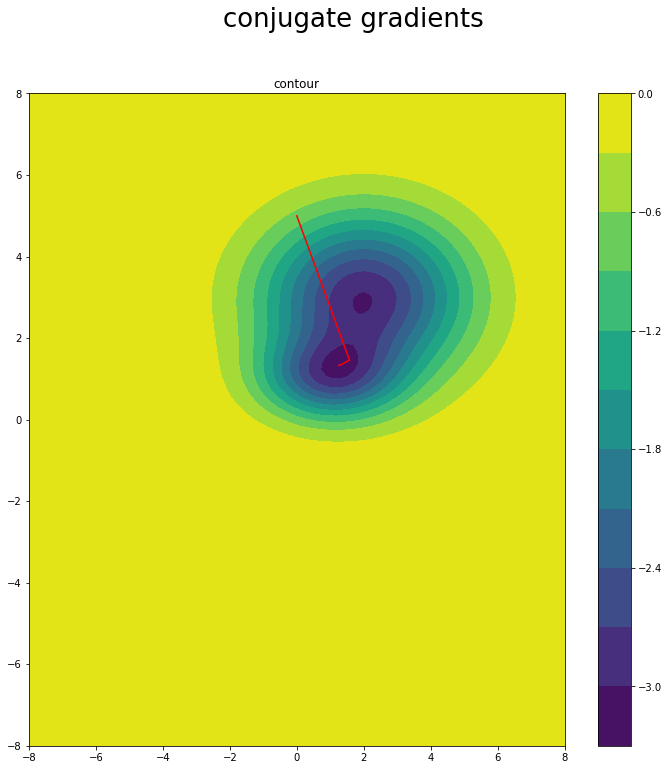

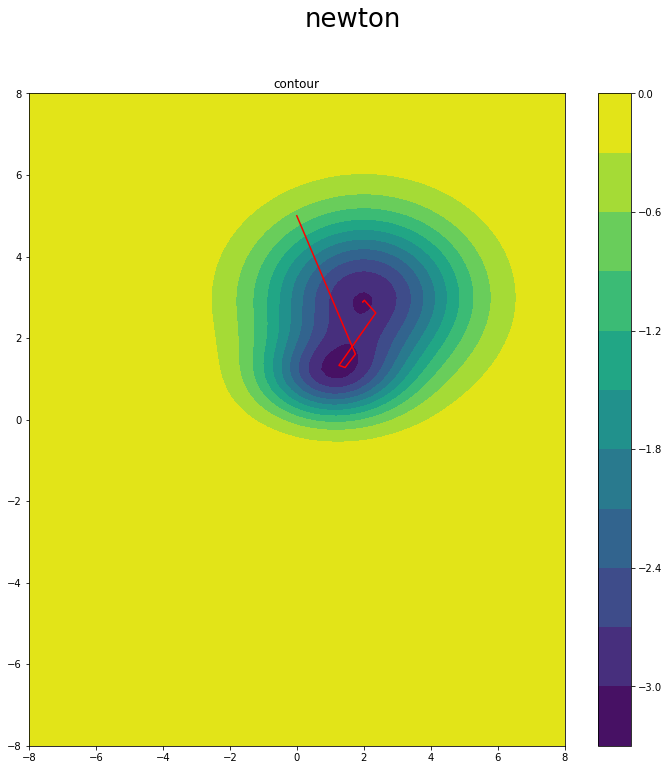

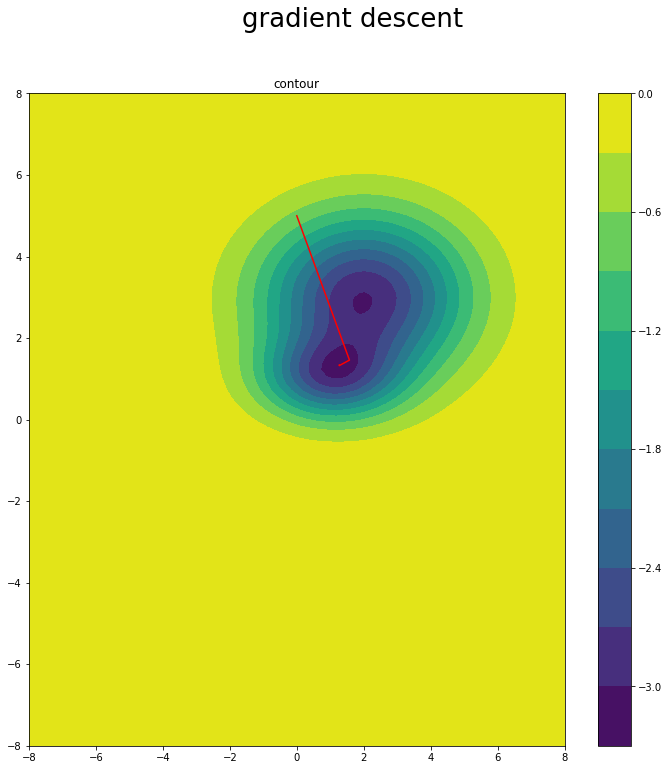

(x1 - 1)**2 + 2*(x1 - x2)**2

'Start point'

Matrix([
[-5],
[ 5]])

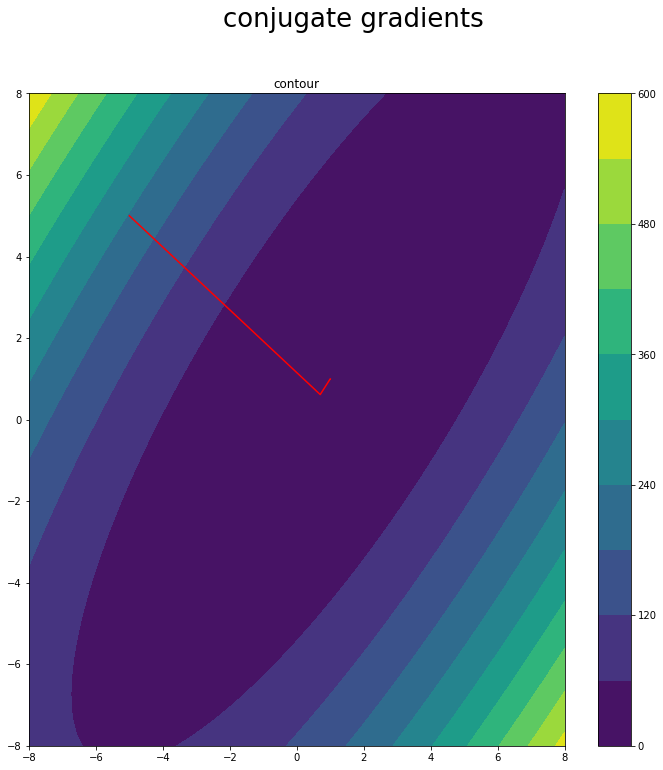

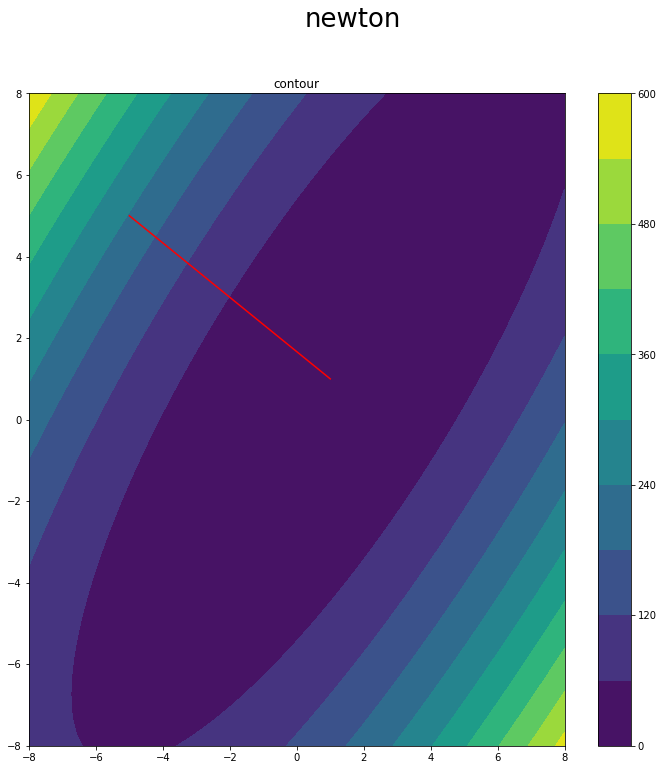

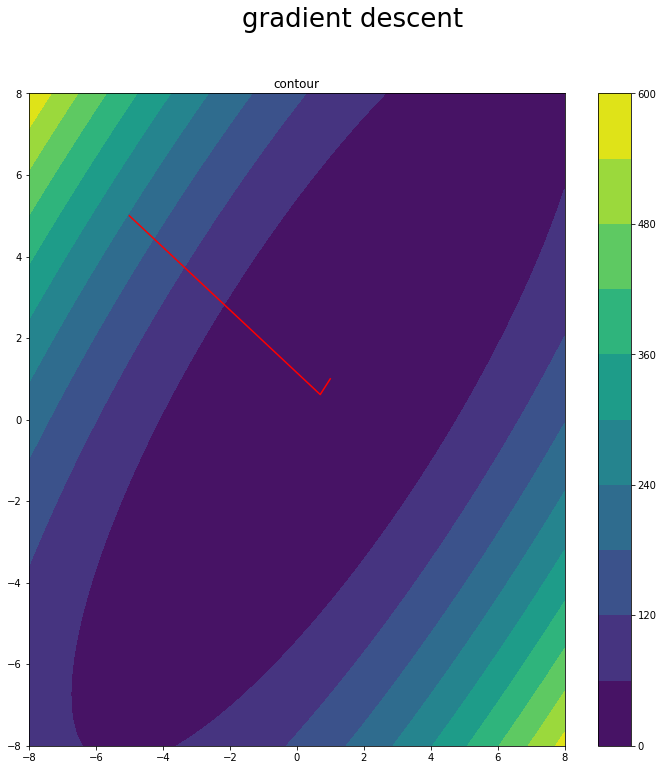

'Start point'

Matrix([
[2],
[5]])

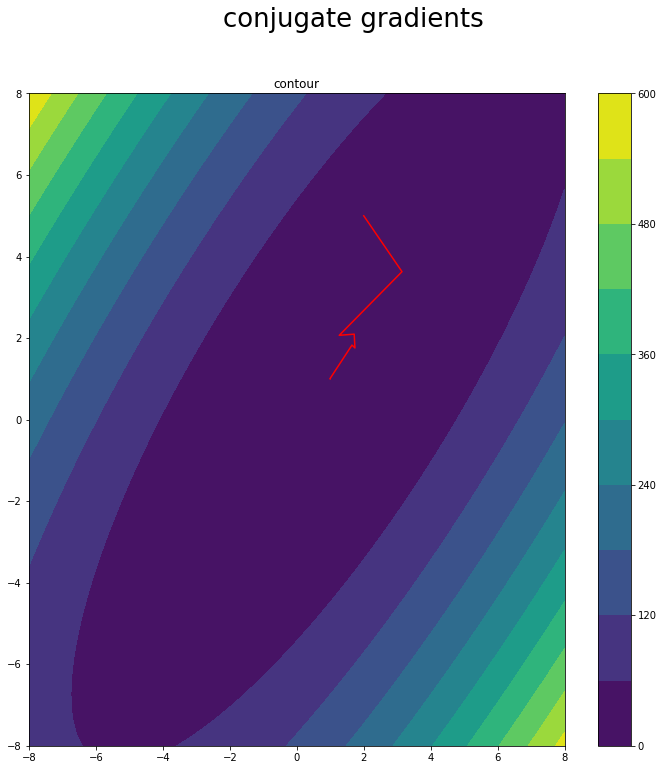

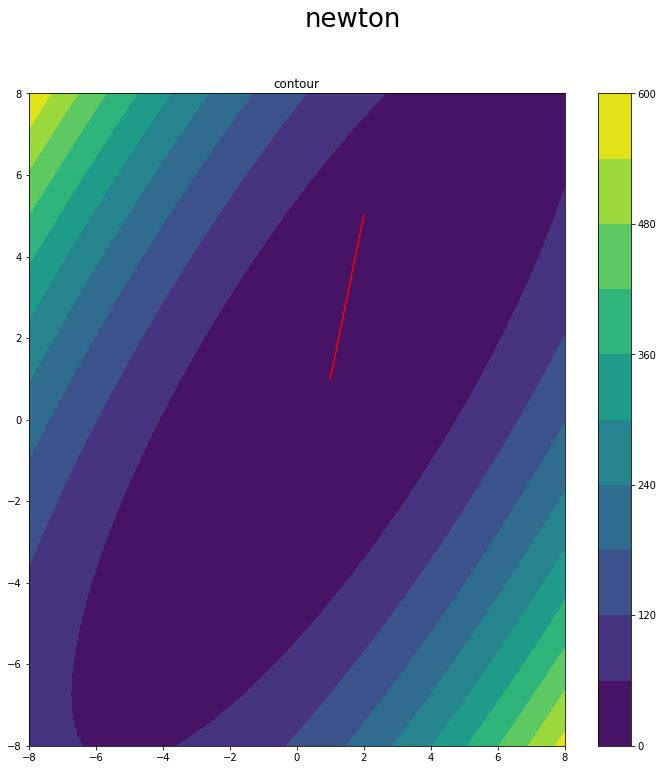

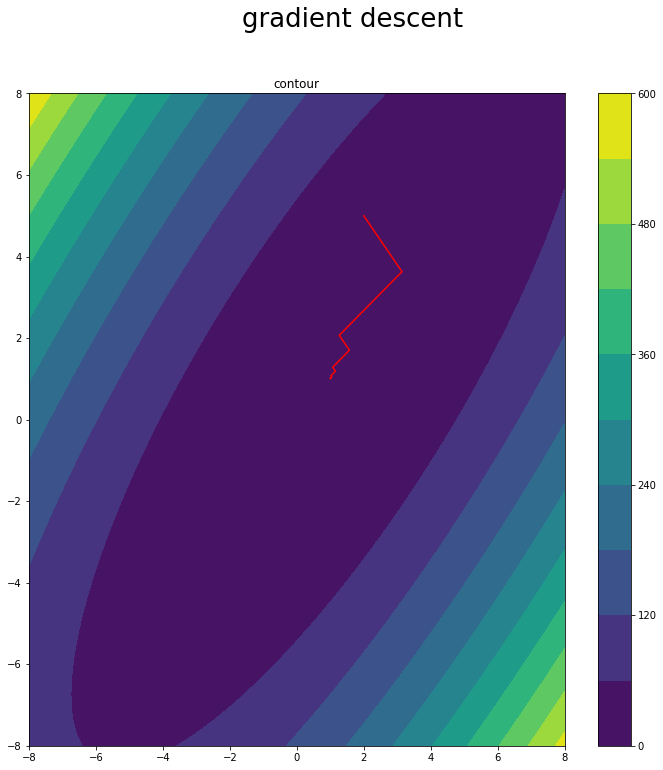

'Start point'

Matrix([
[-5],
[-5]])

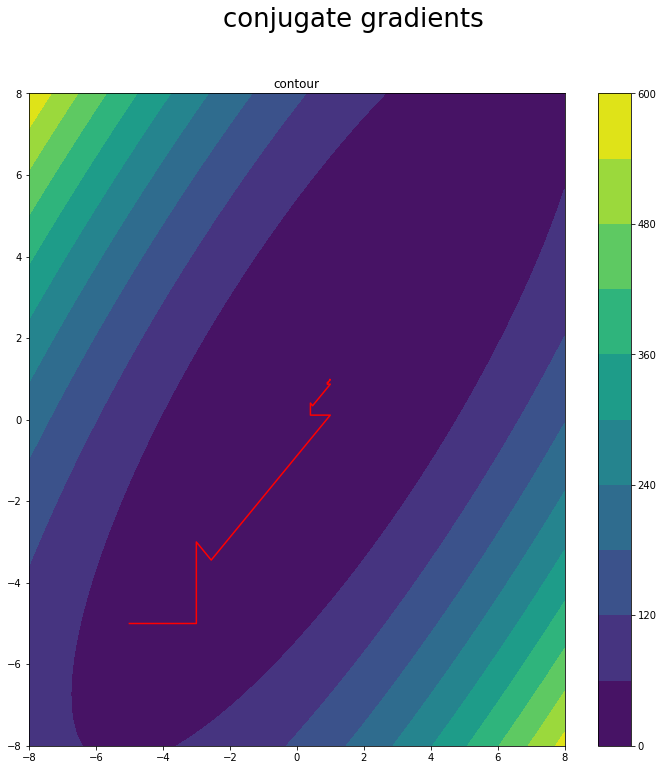

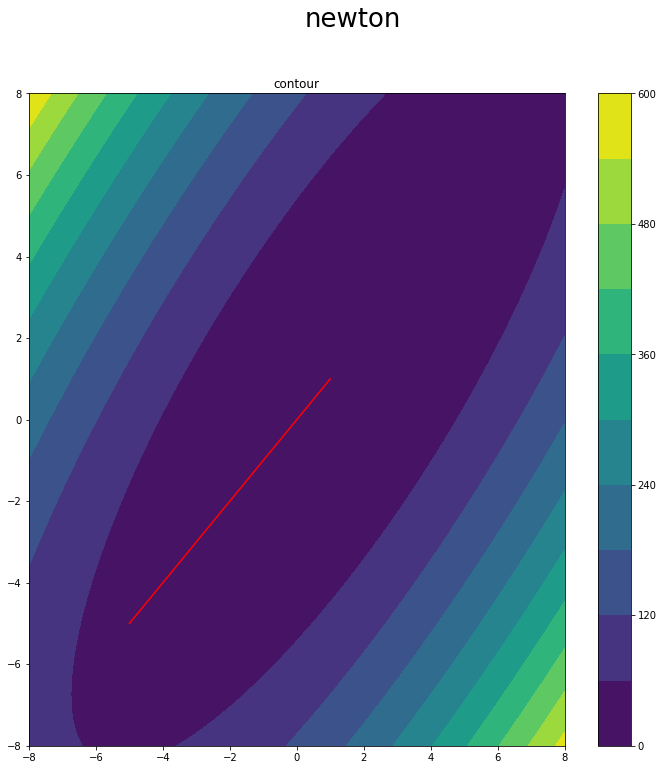

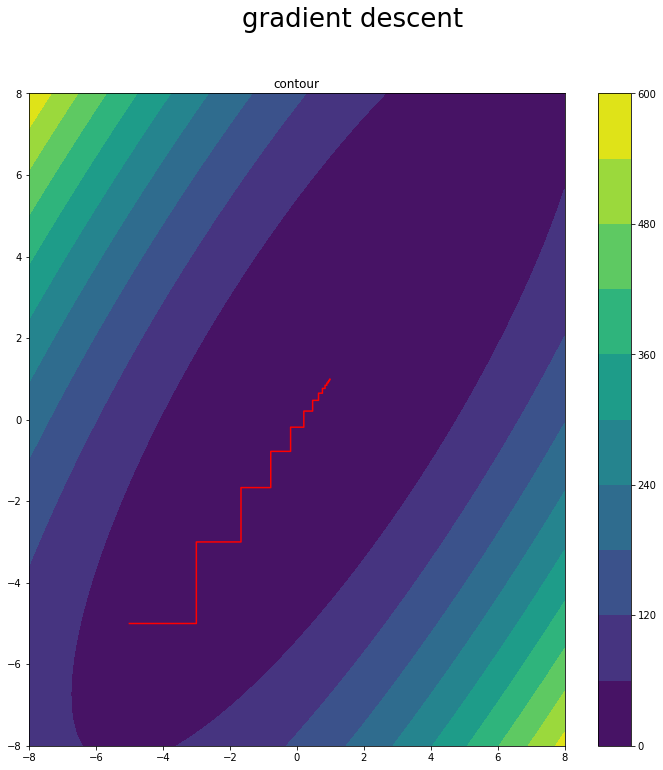

'Start point'

Matrix([
[0],
[5]])

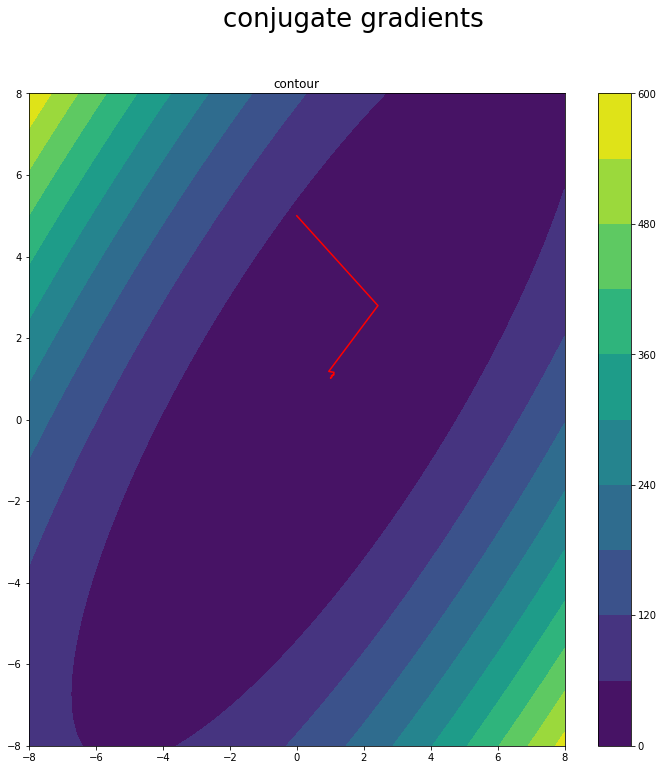

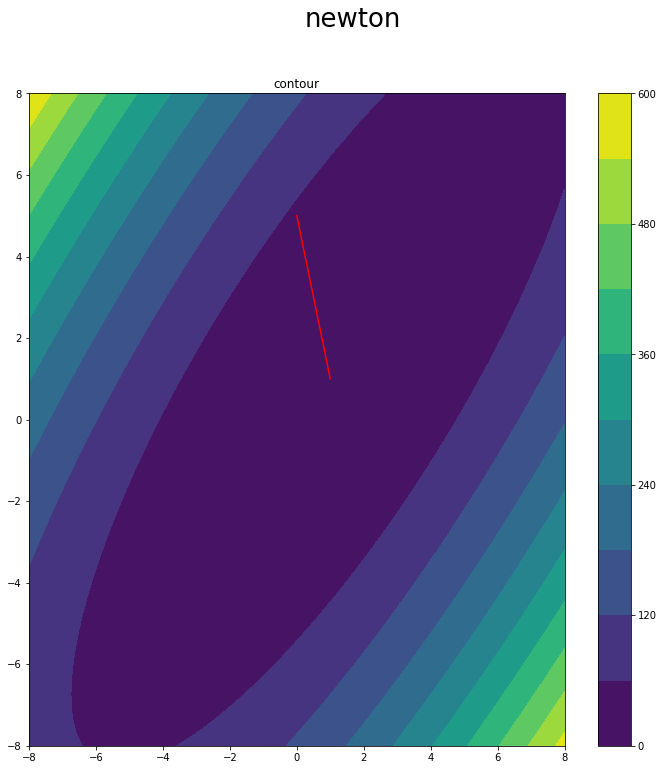

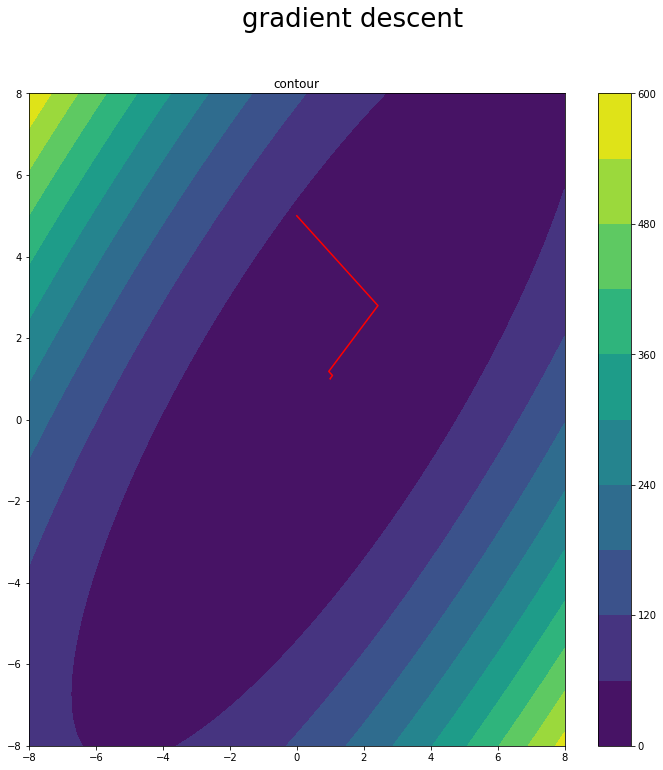

In [14]:

for func in functions_to_compare_on:
    display(func)
    for start_point in start_points:
        display('Start point')
        display(start_point)
        for method in methods:
            result = method[0](OptimizationParameters(func, optimizer_name, start_point, eps))
            pltSize = 8
            better_trajectory(method[1], lambdify((x1, x2), func, 'numpy'), -pltSize, pltSize, -pltSize, pltSize, result.data)




